# GeneOntology DrillDown

Various evaluations of GeneOntolgy + embeddings

In [1]:
%matplotlib inline
%load_ext autoreload   
%autoreload 2

import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

from src.python.geneontology import *
go_graph = initialize_go()

assert nx.is_directed_acyclic_graph(go_graph)

### Node2Vec embeddings of GO terms

In [2]:
import os 

from src.python import node2vec

from gensim.models.word2vec import Word2Vec

from gensim.models.keyedvectors import KeyedVectors

p = 1.0
q = 1.0

num_walks = 10  # defaullt is 10
walk_length = 12  # defaullt is 80

dim = 256
win = 6
sg = 1

model_fname = '/tmp/GO-%s-dim%d-win%d-len%d-iter%d.emb' % ("sg" if sg==1 else "cbow", dim, win, walk_length, num_walks)

def embedding(graph):
    G = node2vec.Graph(graph, True, p, q) # True for directed
    G.preprocess_transition_probs()
    walks = G.simulate_walks(num_walks, walk_length)
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=dim, window=win, min_count=0, sg=sg, workers=4, iter=num_walks)
    model.wv.save(model_fname)
    return model.wv

if os.path.exists(model_fname):
    word_vectors = KeyedVectors.load(model_fname)
else:
    word_vectors = embedding(go_graph)


### Evaluate the embedding of the GO terms

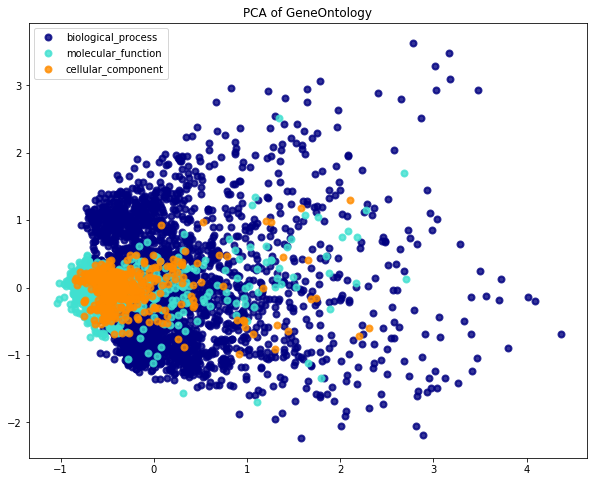

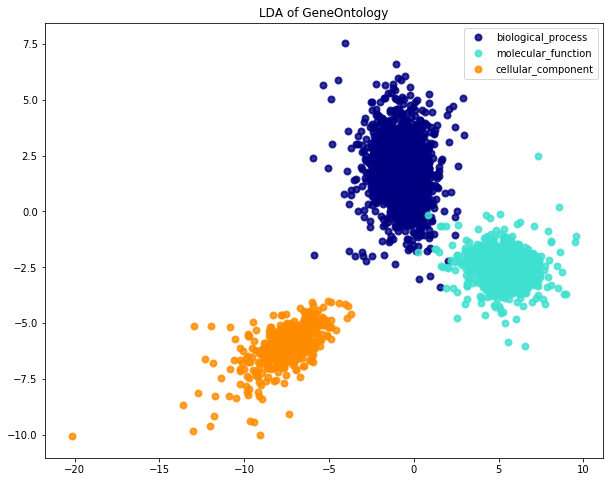

In [3]:

import matplotlib.pyplot as plt

import numpy as np

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def tsne(embeddings):
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    return tsne.fit_transform(embeddings[:, :])


def pca(embeddings):
    pca = PCA(n_components=2)
    return pca.fit_transform(embeddings)

def lda(embeddings, labels):
    lda = LinearDiscriminantAnalysis(n_components=2)
    return lda.fit(embeddings, labels).transform(embeddings)

def plot(title, X_r):
    for color, asp in zip(colors, aspects):
        plt.scatter(X_r[y == asp, 0], X_r[y == asp, 1], color=color, alpha=.8, lw=lw,
                    label=asp)
    plt.title(title)
    plt.legend(loc='best', shadow=False, scatterpoints=1)

    
X = np.array([word_vectors[n] for n in go_graph.nodes()])
nrow = len(X)
indx = np.arange(nrow) % 10 == 0
X = X[indx, :]


colors = ['navy', 'turquoise', 'darkorange']
aspects = ['biological_process', 'molecular_function', 'cellular_component']
lw = 2

y = np.array([attr['namespace'] for _, attr in go_graph._node.items()])[indx]


X_pca = pca(X)
plot('PCA of GeneOntology', X_pca)
plt.show()

X_lda = lda(X, y)
plot('LDA of GeneOntology', X_lda)
plt.show()

# X_tsne = tsne(X)
# plot('t-SNE of GeneOntology', X_tsne)
# plt.show()

### Node2Vec embeddings of the MFO terms

In [4]:
# num_walks = 10  # defaullt is 10
# walk_length = 12  # defaullt is 80

# dim = 256
# win = 6
# sg = 1

# model_fname = '/tmp/MFO-%s-dim%d-win%d-len%d-iter%d.emb' % ("sg" if sg==1 else "cbow", dim, win, walk_length, num_walks)


# def get_ontology_graph(aspect):
#     asp_graph = go_graph.copy()
#     for n, attr in go_graph._node.items():
#         if attr['namespace'] != aspect:
#             asp_graph.remove_node(n)
#     return asp_graph

# onto_graph = get_ontology_graph('molecular_function')

# if os.path.exists(model_fname):
#     word_vectors = KeyedVectors.load(model_fname)
# else:
#     word_vectors = embedding(onto_graph)

### Load Poincaré Embeddings of MFO terms

In [5]:
import os
import numpy as np

from gensim.models.poincare import PoincareModel, PoincareKeyedVectors

mfo = get_ontology('F')
print(mfo)
bpo = get_ontology('P')
print(bpo)
cco = get_ontology('C')
print(cco)

onto_root = mfo.root
onto_graph = mfo._graph
word_vectors = mfo._kv


MFO
#GO-terms	:	11156
max-path	:	17
BPO
#GO-terms	:	29691
max-path	:	17
CCO
#GO-terms	:	4157
max-path	:	12


In [6]:
print(mfo.root)
print(cco.root)
print(bpo.root)

GO:0003674
GO:0005575
GO:0008150


### Evaluate the embedding of the MFO terms

100%
antioxidant activity
binding
catalytic activity
hijacked molecular function
molecular carrier activity
molecular function regulator
molecular transducer activity
signal transducer activity
structural molecule activity
transcription regulator activity
translation regulator activity
transporter activity


/home/yotamfr/development/prot2vec/virtualenv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


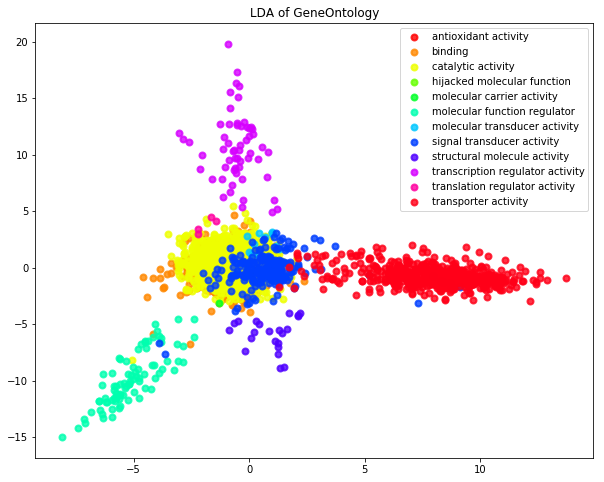

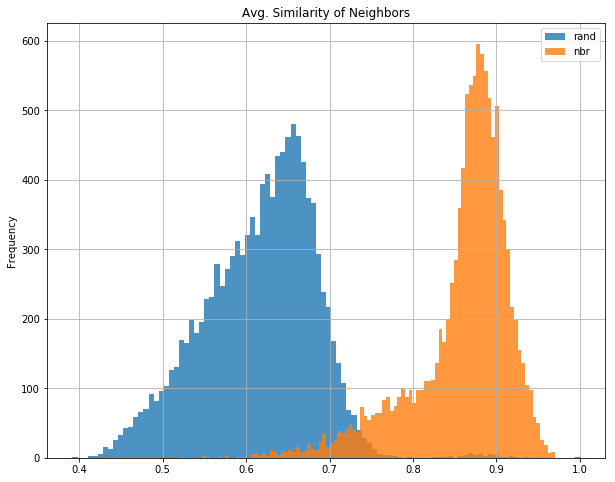

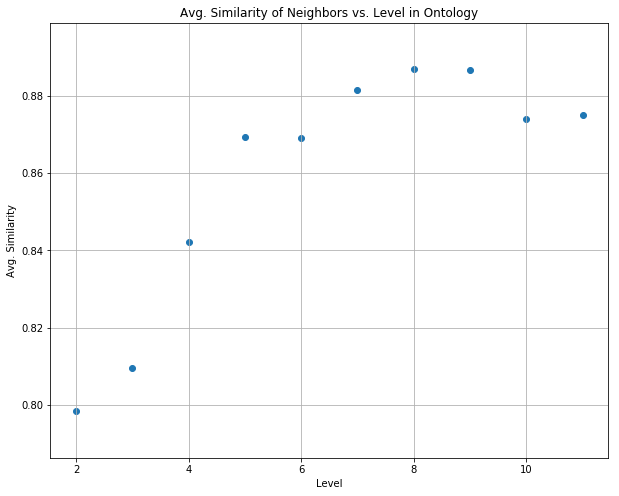

In [7]:
import sys 
hsv = plt.get_cmap('hsv')

def get_level(n, G, root):
    anc = nx.shortest_path_length(G, target=root)
    s = set([k for k, v in anc.items() if (v == n)])
    return s
    
rollups = get_level(1, onto_graph, onto_root)

def eval_function(word_vectors, graph):
    y = []
    X = []
    nn_sim = []
    nn_rank = []
    nn_level = []
    rand_sim = []
    N = len(graph._node)
    nodes = list(graph.nodes())
    
    for i, (n, _) in enumerate(graph._node.items()):
        sys.stdout.write("\r{0:.0f}%".format(100.0 * i/N))
        if n in rollups | {onto_root}:
            continue
        X.append(word_vectors[n])
        desc = nx.descendants(graph, n)
        nbr = list(graph.neighbors(n))
        sample = np.random.choice(nodes, len(nbr))
        rand_sim.append(np.mean([word_vectors.similarity(n, v) for v in sample]))
        nn_sim.append(np.mean([word_vectors.similarity(n, u) for u in nbr]))
#         nn_rank.append(np.mean([word_vectors.rank(n, u) for u in nbr]))
        k = nx.shortest_path_length(graph, source=n, target=onto_root)
        nn_level.append(k)
        for go in [go for go in rollups if go in desc]:
            rollup = graph._node[go]['name']
            y.append(rollup)
            break
    return X, y, rand_sim, nn_sim, nn_rank, nn_level


X, y, RAND_sim, NN_sim, NN_rank, NN_lvl = eval_function(word_vectors, onto_graph)

aspects = np.unique(y)
print("\n" + "\n".join(aspects))
colors = hsv(np.linspace(0, 1.0, len(aspects)))
lw = 2

N = len(y)
indx = np.arange(N) % 2 == 0 # Just plot Half of'em
X = np.array(X)[indx, :]
y = np.array(y)[indx]

X_lda = lda(X, y)
plot('LDA of GeneOntology', X_lda)
plt.show()

# X_tsne = tsne(X)
# plot('t-SNE of GeneOntology', X_tsne)
# plt.show()

plt.hist(RAND_sim, bins=100, alpha=0.8, label='rand')
plt.hist(NN_sim, bins=100, alpha=0.8, label='nbr')
plt.legend(loc='upper right')
plt.title("Avg. Similarity of Neighbors")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# plt.hist(NN_rank, bins=200, range=(0, np.percentile(NN_rank, 95)))
# plt.title("Avg. Rank of Neighbors")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()

NN_lvl = np.array(NN_lvl)
NN_sim = np.array(NN_sim)
levels = np.unique(NN_lvl)

y = list(map(lambda lvl: np.mean(NN_sim[NN_lvl == lvl]), levels))

plt.scatter(levels, y)
plt.title("Avg. Similarity of Neighbors vs. Level in Ontology")
plt.xlabel("Level")
plt.ylabel("Avg. Similarity")
plt.grid(True)
plt.show()

### Load dataset

In [8]:
from src.python.preprocess import *

from pymongo import MongoClient


client = MongoClient("mongodb://127.0.0.1:27017")
# client = MongoClient("mongodb://192.168.1.14:27017")

db = client['prot2vec']

dataset, _ = load_data(db, 'F', limit=200000)

dataset.augment()

print(dataset)    

100%
Finished loading 34913 mappings!
100%
Finished loading 20502 sequences!
100%
#Annotaions	236663
#GO-Terms	5041
#Sequences	20502


### Evaluate the predictive power of the MFO terms embedding

In [11]:
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import precision_recall_fscore_support

augment_nn = True

cls = dataset.onto.classes
n_cls = len(cls)
N = len(dataset)

y_truth = np.zeros((N, n_cls))
y_pred = np.zeros((N, n_cls))

macro, micro = {}, {}
tops = [1, 3, 5, 10]

for top in tops:
    
    print("\ntop%d\n" % top)
    
    for i, r in enumerate(dataset.records):
        sys.stdout.write("\r{0:.0f}%".format(100.0 * i/N))
        labels = r.lbl
        if len(labels) == 0: 
            continue
        y_truth[i, :] =  dataset.onto.binarize([labels])
        label_vecotrs = [word_vectors[go] for go in labels if go in word_vectors]
        centroid = np.mean(label_vecotrs, axis=0)
        nn = word_vectors.most_similar(centroid, topn=top)  
        nn = set([go for go, _ in nn if go in cls])
        if augment_nn:
            anc = map(lambda go: nx.descendants(onto_graph, go), nn)
            nn = reduce(lambda x, y: x | y, anc, nn)
        y_pred[i, :] = dataset.onto.binarize([nn])

    y_truth = np.array(y_truth)
    y_pred = np.array(y_pred)
    
    score = np.zeros((n_cls, 3))
    for j in range(n_cls):
        sys.stdout.write("\r%d\t/\t%d" % (j, n_cls))
        pr, rc, f1, _ = precision_recall_fscore_support(y_truth[:, j], y_pred[:, j], beta=1.0, average="binary")
        score[j, :] = np.array([pr, rc, f1])
        
    ### macro
    macro[top] = np.mean(score, axis=0) # compute the macro score
    
    ### micro
    micro[top] = precision_recall_fscore_support(y_truth, y_pred, beta=1.0, average="micro")
    
    print("\nmicro\tpr=%.2f\trc=%.2f\tf1=%.2f" % (micro[top][0], micro[top][1], micro[top][2]))
    print("\nmacro\tpr=%.2f\trc=%.2f\tf1=%.2f" % (macro[top][0], macro[top][1], macro[top][2]))




top1

14	/	11156

/home/yotamfr/development/prot2vec/virtualenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yotamfr/development/prot2vec/virtualenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


11155	/	11156
micro	pr=0.61	rc=0.27	f1=0.37

macro	pr=0.04	rc=0.02	f1=0.02

top3

11155	/	11156
micro	pr=0.51	rc=0.36	f1=0.42

macro	pr=0.06	rc=0.03	f1=0.03

top5

11155	/	11156
micro	pr=0.42	rc=0.40	f1=0.41

macro	pr=0.07	rc=0.04	f1=0.04

top10

11155	/	11156
micro	pr=0.30	rc=0.46	f1=0.36

macro	pr=0.08	rc=0.07	f1=0.06


### Plot the F1 score

In [12]:

###https://matplotlib.org/examples/api/barchart_demo.html
def plot_pr_rc_f1(title, scores):
    
    N = len(scores)
    pr = [v[0] for v in scores.values()] 
    rc = [v[1] for v in scores.values()]
    f1 = [v[2] for v in scores.values()]


    ind = np.arange(N)  # the x locations for the groups
    width = 0.2       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, pr, width, color='r')
    rects2 = ax.bar(ind + width, rc, width, color='g')
    rects3 = ax.bar(ind + width * 2, f1, width, color='b')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(list(scores.keys()))

    ax.legend((rects1[0], rects2[0], rects3[0]), ('prec', 'recall', 'f1'))
    
    autolabel(rects1, ax)
    autolabel(rects2, ax)
    autolabel(rects3, ax)


def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % height,
                ha='center', va='bottom')

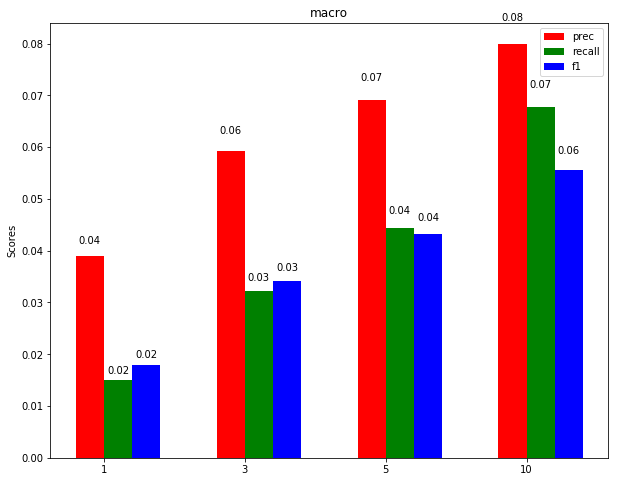

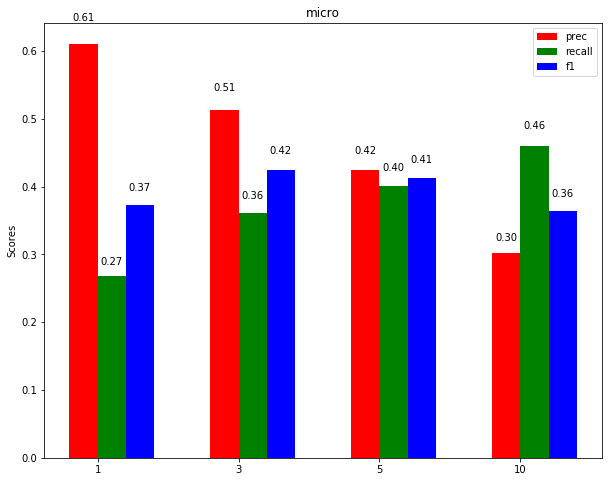

In [13]:
plot_pr_rc_f1("macro", macro)
plot_pr_rc_f1("micro", micro)

plt.show()